## Fitting Spline kernel on CAMELS 

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"


In [2]:
%pylab inline
from tqdm import tqdm

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import jax_cosmo as jc

mesh_shape= [64, 64, 64]
box_size  = [25., 25., 25.]
cosmo = jc.Planck15(Omega_c= 0.3 - 0.049, Omega_b=0.049, n_s=0.9624, h=0.6711, sigma8=0.8)

In [4]:
#import camels_library as cl
import readgadget

init_cond = '/data/CAMELS/Sims/IllustrisTNG_DM/CV_0/ICs/ics'

header   = readgadget.header(init_cond)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

ptype = [1] #dark matter is particle type 1
ids_i = np.argsort(readgadget.read_block(init_cond, "ID  ", ptype)-1)  #IDs starting from 0
pos_i = readgadget.read_block(init_cond, "POS ", ptype)[ids_i]/1e3     #positions in Mpc/h
vel_i = readgadget.read_block(init_cond, "VEL ", ptype)[ids_i]         #peculiar velocities in km/s

# Reordering data for simple reshaping
pos_i = pos_i.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
vel_i = vel_i.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
pos_i = (pos_i/BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
vel_i = (vel_i / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
a_i   = 1./(1+redshift)

In [5]:
scales = []
poss = []
vels = []

# Loading all the intermediate snapshots
for i in tqdm(range(34)):
    snapshot='/data/CAMELS/Sims/IllustrisTNG_DM/CV_0/snap_%03d.hdf5'%i
    
    header   = readgadget.header(snapshot)
    
    redshift = header.redshift     #redshift of the snapshot
    h        = header.hubble       #value of h
    
    ptype = [1] #dark matter is particle type 1
    ids = np.argsort(readgadget.read_block(snapshot, "ID  ", ptype)-1)     #IDs starting from 0
    pos = readgadget.read_block(snapshot, "POS ", ptype)[ids] / 1e3        #positions in Mpc/h
    vel = readgadget.read_block(snapshot, "VEL ", ptype)[ids]              #peculiar velocities in km/s

    # Reordering data for simple reshaping
    pos = pos.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    vel = vel.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    
    pos = (pos / BoxSize * 64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    vel = (vel / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    
    scales.append((1./(1+redshift)))
    poss.append(pos)
    vels.append(vel)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [01:44<00:00,  3.07s/it]


In [6]:
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import haiku as hk


from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.pm import linear_field, lpt, make_ode_fn, pm_forces
from jaxpm.kernels import fftk, gradient_kernel, laplace_kernel, longrange_kernel
from jaxpm.nn import NeuralSplineFourierFilter
from jaxpm.utils import power_spectrum
import numpyro 
rng_seq = hk.PRNGSequence(1)

In [7]:
# Run the reference simulation without correction at the same steps
resi = odeint(make_ode_fn(mesh_shape), [poss[0], vels[0]], jnp.array(scales), cosmo, rtol=1e-5, atol=1e-5)

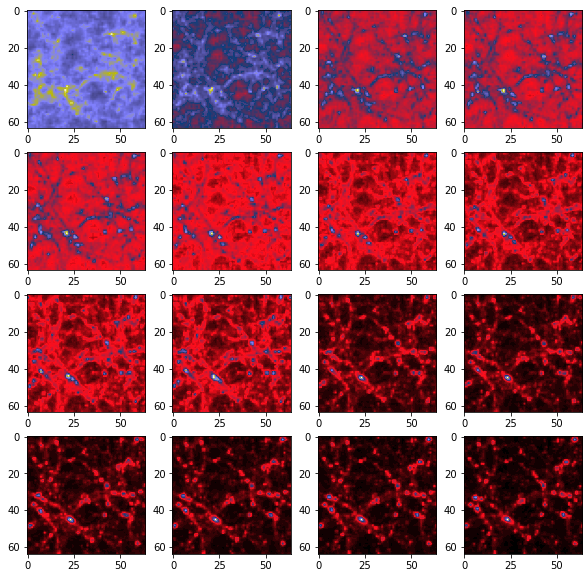

In [8]:
# High res simulation
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0), cmap='gist_stern', vmin=0)

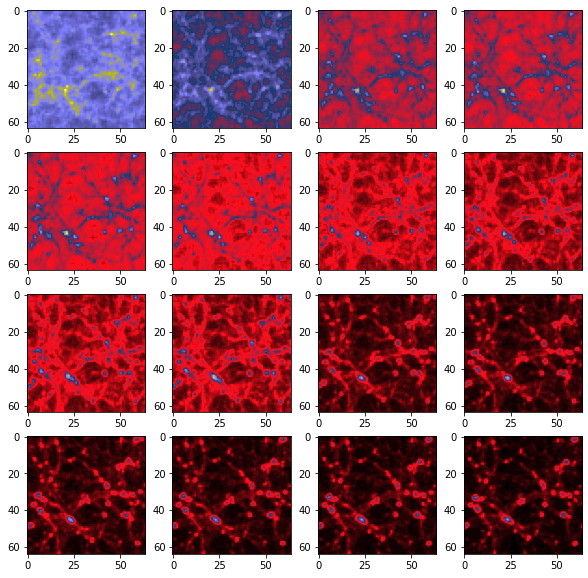

In [9]:
# JaxPM without correction
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), resi[0][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0).max(),vmin=0)

In [10]:
k, pk_ref = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), poss[-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_i = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), resi[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

/local/home/dl264294/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


Text(0, 0.5, '$P(k)$')

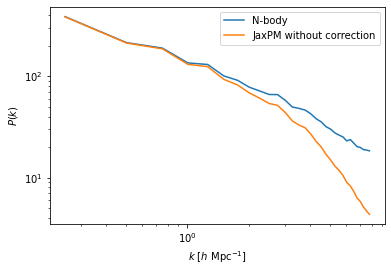

In [11]:
loglog(k,pk_ref, label='N-body')
loglog(k,pk_i, label='JaxPM without correction')
legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")

### Fitting PGD

In [12]:
kl0 = 0.3
ks0=10.
alpha0=0.3
params=[alpha0,kl0,ks0]

In [13]:
def PGD_kernel(kvec, kl, ks):

  kk = sum(ki**2 for ki in kvec)
  kl2 = kl**2
  ks4 = ks**4
  mask = (kk == 0).nonzero()
  kk[mask] = 1
  v = jnp.exp(-kl2 / kk) * jnp.exp(-kk**2 / ks4)
  imask = (~(kk == 0)).astype(int)
  v *= imask
  return v

In [14]:
def pgd_correction(pos, cosmo, params):
    """
    state is a tuple (position, velocities)
    """

    
    kvec = fftk(mesh_shape)

    delta = cic_paint(jnp.zeros(mesh_shape), pos)
    alpha, kl, ks = params
    delta_k = jnp.fft.rfftn(delta)
    PGD_range=PGD_kernel(kvec, kl, ks)
    
    pot_k_pgd=(delta_k * laplace_kernel(kvec))*PGD_range

    forces_pgd= jnp.stack([cic_read(jnp.fft.irfftn(gradient_kernel(kvec, i)*pot_k_pgd), pos) 
                      for i in range(3)],axis=-1)
    forces_pgd = forces_pgd * 1.5 * cosmo.Omega_m
    
    dpos_pgd = forces_pgd*alpha
   
    return dpos_pgd

In [15]:
# Precomputing a few data stuff
ref_pos = jnp.stack(poss, axis=0)
ref_vel = jnp.stack(vels, axis=0)
ref_pk = jax.vmap(lambda x: power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), x)),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)[1])(ref_pos)

/local/home/dl264294/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


In [16]:
idex=-1

In [17]:
@jax.jit
def loss_fn(params):
  res = odeint(make_ode_fn(mesh_shape), [poss[0], vels[0]], jnp.array(scales), cosmo, rtol=1e-5, atol=1e-5)
  pdgized_state= res[0][index] + pgd_correction(res[0][index], cosmo, params)
  pk=power_spectrum(cic_paint(jnp.zeros(mesh_shape), pdgized_state),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)[1]
  return jnp.mean(jnp.sum((pk/ref_pk[index] -1)**2,axis=-1)) 

@jax.jit
def update(params, opt_state):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, new_opt_state

In [18]:
import optax
learning_rate=0.01
optimizer = optax.adam(learning_rate)

In [19]:
losses = []
opt_state = optimizer.init(params)

In [20]:
index=-1

In [21]:

for step in tqdm(range(400)):
  l, params, opt_state = update(params, opt_state)
  losses.append(l)

  0%|                                                                                                                                                                               | 0/400 [00:00<?, ?it/s]/tmp/ipykernel_703383/3475760157.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kk = sum(ki**2 for ki in kvec)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:41<00:00,  2.48it/s]


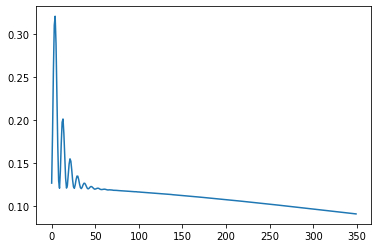

In [23]:
plot(losses[50:])
#learning_rate=0.01
#iteration =400

In [22]:
k, pk_ref = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), poss[index])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_i = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), resi[0][index])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_c = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), resi[0][index]+pgd_correction(resi[0][index], cosmo,params))),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

/tmp/ipykernel_703383/3475760157.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kk = sum(ki**2 for ki in kvec)


Text(0, 0.5, '$P(k)$')

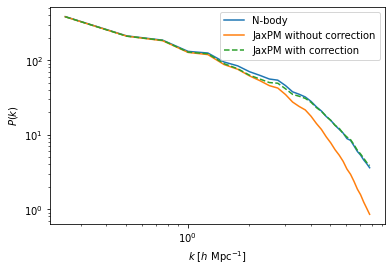

In [24]:
loglog(k, pk_ref, label='N-body')
loglog(k, pk_i, label='JaxPM without correction')
loglog(k, pk_c, '--', label='JaxPM with correction')
legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")
#learning_rate=0.01
#iteration =400

In [27]:
import pickle
pickle.dump( params, open( "camels_25_64_pkloss_PGD.params", "wb" ) )